In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [1]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils
from notebook_shared import violinplotutil

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "full"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))

In [2]:
df[['driver_invocation', 'workload_invocation', 'provider', 'region', '1_run_id']]

,driver_invocation,workload_invocation,provider,region,1_run_id
0,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,0
1,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,0
2,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,0
3,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,0
4,2021-08-01 13:30:03.035,2021-08-01 13:30:42.746,AWS,ap-northeast-1,1
...,...,...,...,...,...
49935595,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,148
49935596,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,149
49935597,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,149
49935598,2021-09-30 23:30:03.438,2021-09-30 23:30:22.629,GCP,us-west4,149


In [3]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = df.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
    for measure_group in row['measure group']:
        region = row['region']
        provider = row['provider']
        measure_group = row['measure group'][0]
        provider_region_mapping[f"({provider}, {region})"] = {'region': region, 'measure group': measure_group, 'provider': provider}
        provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {'region': region, 'measure group': measure_group, 'provider': provider}

# Mean Runtime and CV Per Provider
- Q: Has a provider a overall characterstics or do specific regions stand out?
- Q: Does have one provider an overall more volatile region?

In [4]:
cov_df = df.groupby( ['provider', 'region'], observed=True)['runtime'].apply(utils.cov)

AWS


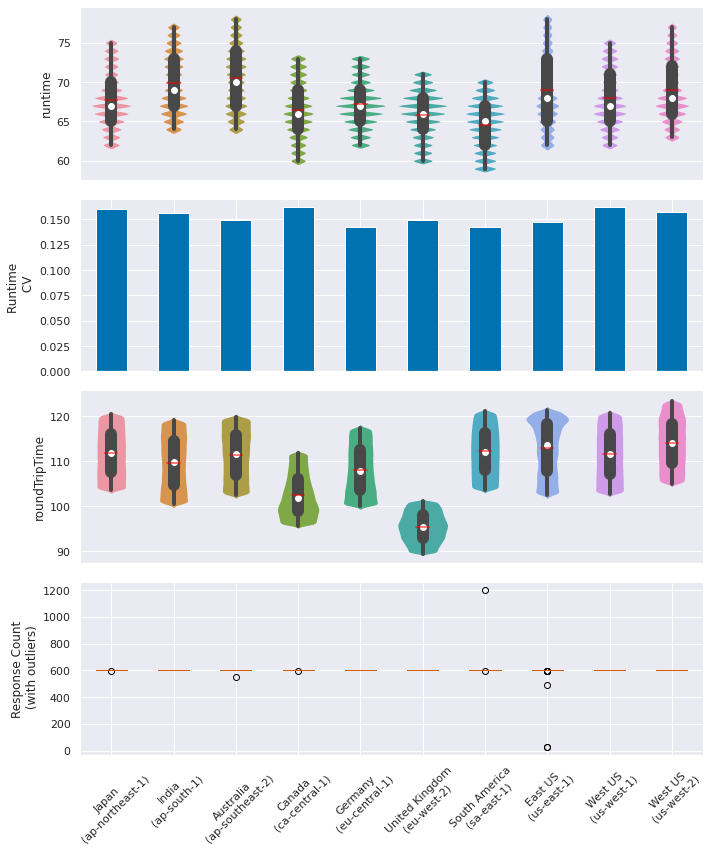

runtimebx 
                           runtime                                         \
                            count       mean       std   min   25%   50%   
provider region                                                            
AWS      ap-northeast-1  926387.0  67.779340  3.507182  62.0  65.0  67.0   
         ap-south-1      871720.0  69.873786  3.818698  64.0  67.0  69.0   
         ap-southeast-2  945986.0  70.484830  4.022142  64.0  67.0  70.0   
         ca-central-1    923543.0  66.469524  3.631024  60.0  64.0  66.0   
         eu-central-1    904657.0  67.237836  2.954712  62.0  65.0  67.0   
         eu-west-2       926541.0  65.859413  2.972326  60.0  64.0  66.0   
         sa-east-1       914609.0  64.603310  3.100743  59.0  62.0  65.0   
         us-east-1       933410.0  68.948700  4.664786  62.0  65.0  68.0   
         us-west-1       901966.0  67.936187  3.653996  62.0  65.0  67.0   
         us-west-2       943479.0  69.012228  3.867792  63.0  66.0  68.0   


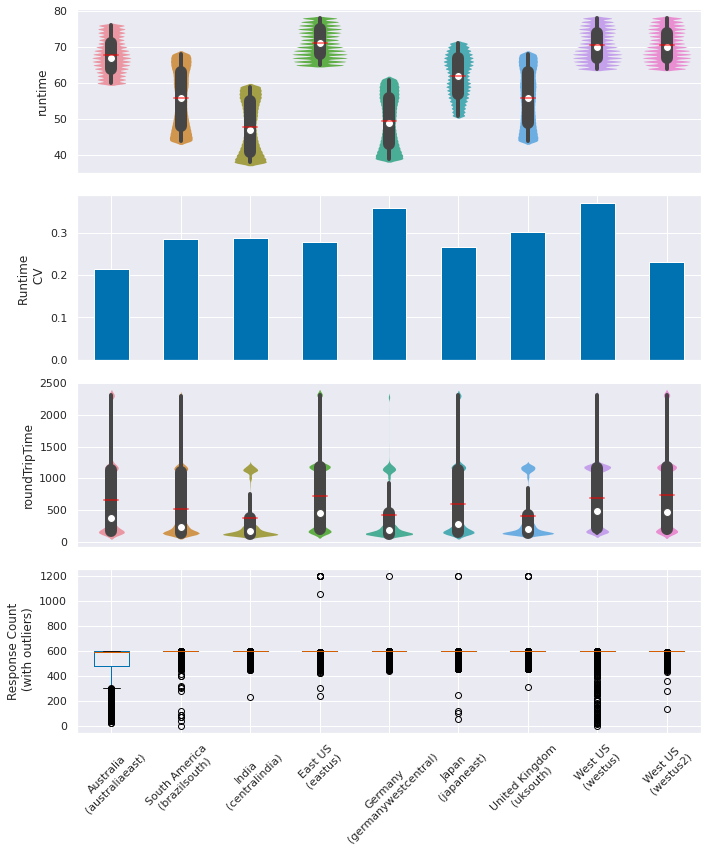

runtimebx 
                               runtime                                         \
                                count       mean       std   min   25%   50%   
provider region                                                                
AZURE    australiaeast       791029.0  67.717206  4.673027  60.0  64.0  67.0   
         brazilsouth         890645.0  55.839857  7.842681  44.0  48.0  56.0   
         centralindia        879161.0  47.853478  7.073692  38.0  41.0  47.0   
         eastus              924545.0  71.017867  4.001760  65.0  68.0  71.0   
         germanywestcentral  900423.0  49.398828  7.127824  39.0  43.0  49.0   
         japaneast           890760.0  61.960560  5.607318  51.0  57.0  62.0   
         uksouth             895755.0  55.959593  7.537987  44.0  49.0  56.0   
         westus              914007.0  70.459758  4.238704  64.0  67.0  70.0   
         westus2             914071.0  70.531010  4.231152  64.0  67.0  70.0   

                           

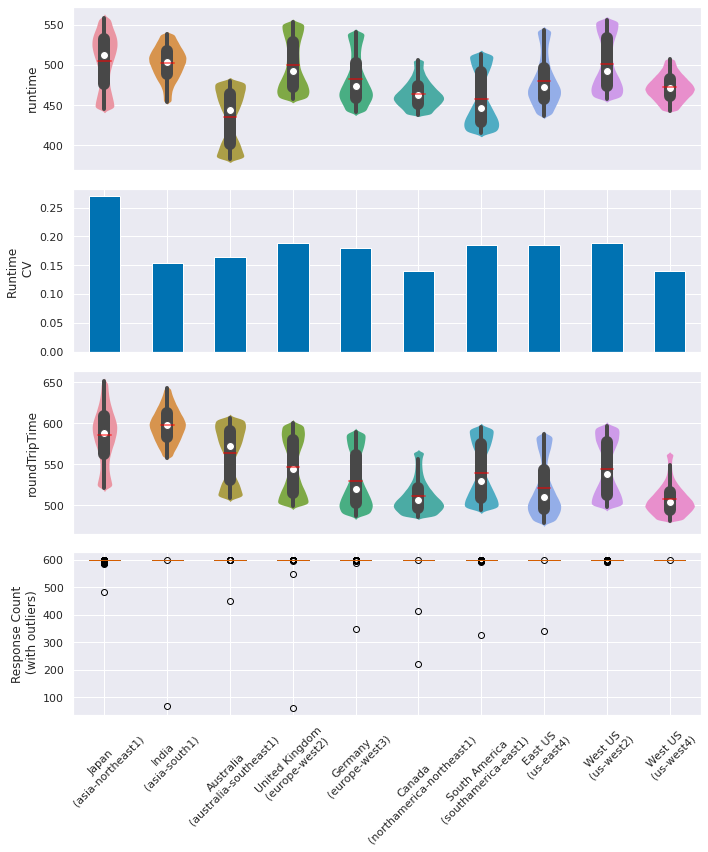

runtimebx 
                                    runtime                                \
                                     count        mean        std    min   
provider region                                                            
GCP      asia-northeast1          883224.0  505.174002  32.888018  445.0   
         asia-south1              872872.0  502.361271  19.932936  454.0   
         australia-southeast1     881507.0  435.199654  32.192091  383.0   
         europe-west2             872649.0  499.592205  30.354491  457.0   
         europe-west3             877572.0  481.894707  28.461980  441.0   
         northamerica-northeast1  872616.0  464.305939  16.154973  438.0   
         southamerica-east1       888317.0  457.155115  32.298694  415.0   
         us-east4                 875937.0  479.939366  28.431815  437.0   
         us-west2                 887440.0  501.672008  31.369217  458.0   
         us-west4                 872538.0  471.936208  15.038465  443.0   


In [5]:
for provider in df['provider'].unique():
    SHAREX = True
    fig, axes = plt.subplots(figsize=(10,12), nrows=4, frameon=False, sharex=SHAREX)
    
    # Runtime
    # bxdf = df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['provider','region'], observed=True)
    # utils.boxplot(axes[0], bxdf, "Runtime\n Boxplots", lambda x: x, rot=90, sharex=SHAREX)
    # vioplot(df, provider)
    pdf = df[['provider', 'region', 'runtime']][df['provider'] == provider]
    pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'runtime')
    violinplotutil.vioplot(pdf, axes[0], 'runtime')
    
    bxdf = pdf.groupby(['provider','region'], observed=True)
    
    # COV
    cov_provider = cov_df.loc[provider]
    cov_provider.plot(kind='bar', ax=axes[1], sharex=SHAREX)
    axes[1].set_ylabel('Runtime \n CV')
    
    # Round Trip Time
    if (provider == "AWS"):
        pdf = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider]
        
        # pdf = utils.remove_outliers_group(pdf, 'region', 'roundTripTime')
        pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'roundTripTime')
        violinplotutil.vioplot(pdf, axes[2], 'roundTripTime')
        rtt_df = pdf.groupby(['region'], observed=True)
        # utils.boxplot(axes[2], rtt_df, 'Round Trip Time', lambda x: x, rot=90, sharex=SHAREX, showfliers=True)
    else:
        pdf = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider]
        pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'roundTripTime')
        violinplotutil.vioplot(pdf, axes[2], 'roundTripTime')
        rtt_df = pdf.groupby(['region'], observed=True)
       
    # resp df
    resp_df = df[df['provider'] == provider].groupby( ['provider', 'region', 'driver_invocation'], observed=True).size().reset_index(name='counts')
    df_boxplot = resp_df[['provider', 'region', 'counts']].groupby(['provider', 'region'], observed=True)
    ax = utils.boxplot(axes[3], df_boxplot, 'Response Count\n (with outliers)', lambda x: x, rot=45, sharex=False, showfliers=True)
    
    # Set Region Names
    region_name_ax = ax
    labels = []
    for tick in region_name_ax.get_xticklabels():
        region = tick.get_text().split(',')[1].strip()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")

    region_name_ax.set_xticklabels(labels)
    region_name_ax.set_xlabel('')

    fig.tight_layout()

    print(provider)
    utils.plot( ['region_analysis', f'overview_{provider}'], runtimebx=bxdf.describe(), rttbx=rtt_df.describe(), respbx=resp_df.describe(), cov=cov_provider)

## Runtime Distribution Across All Providers

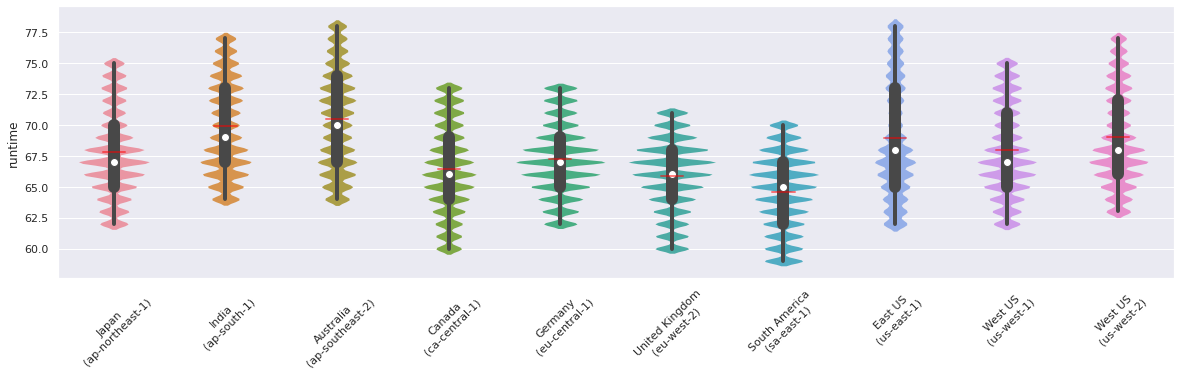

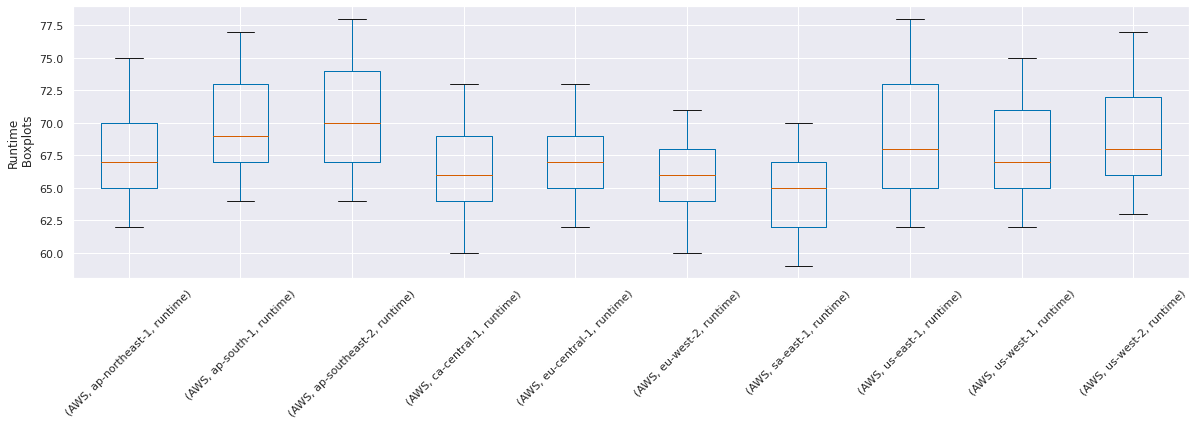

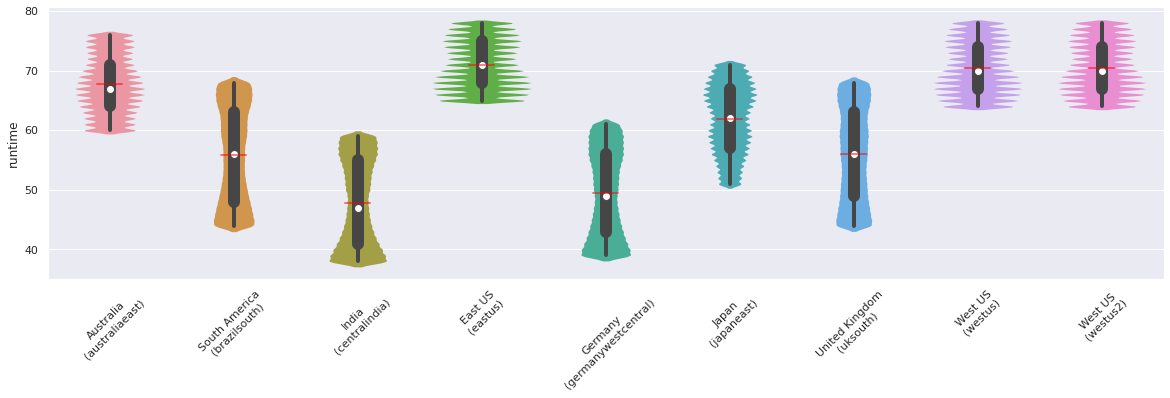

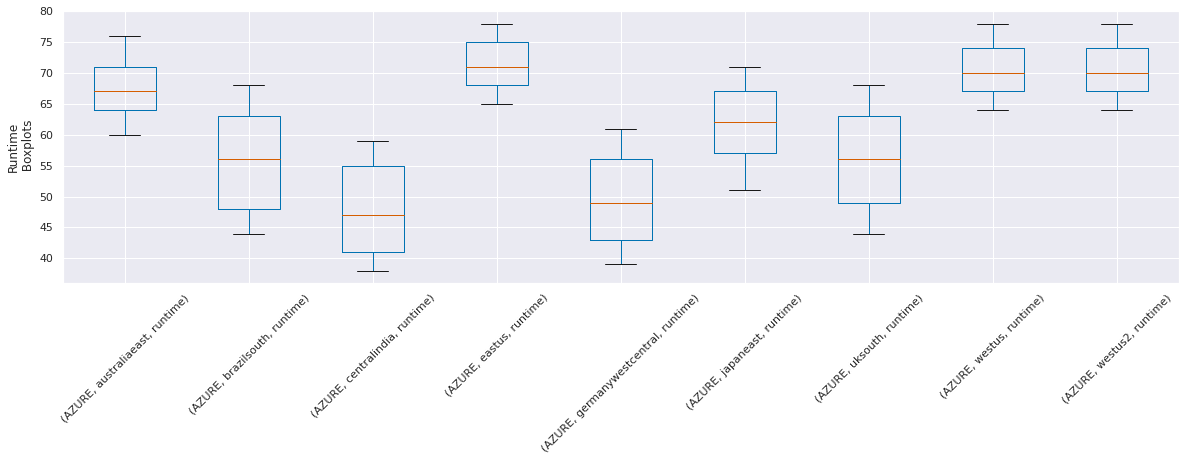

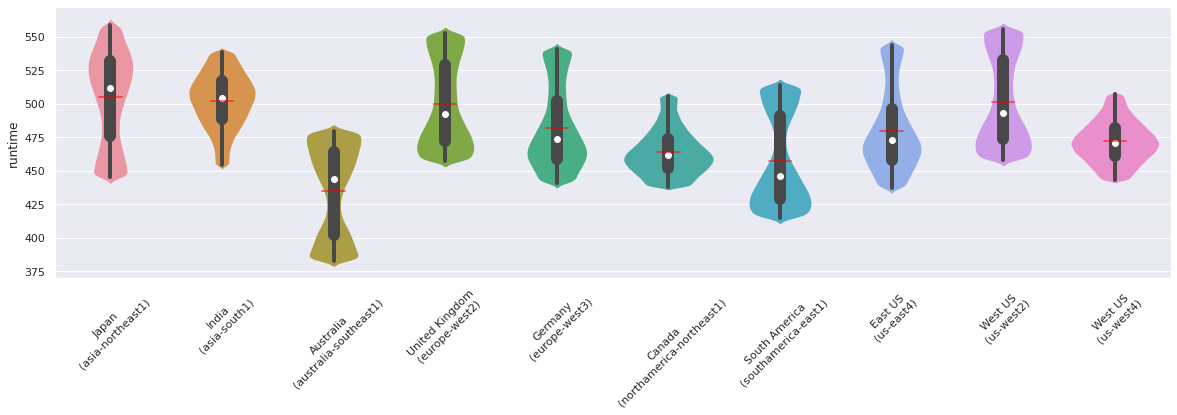

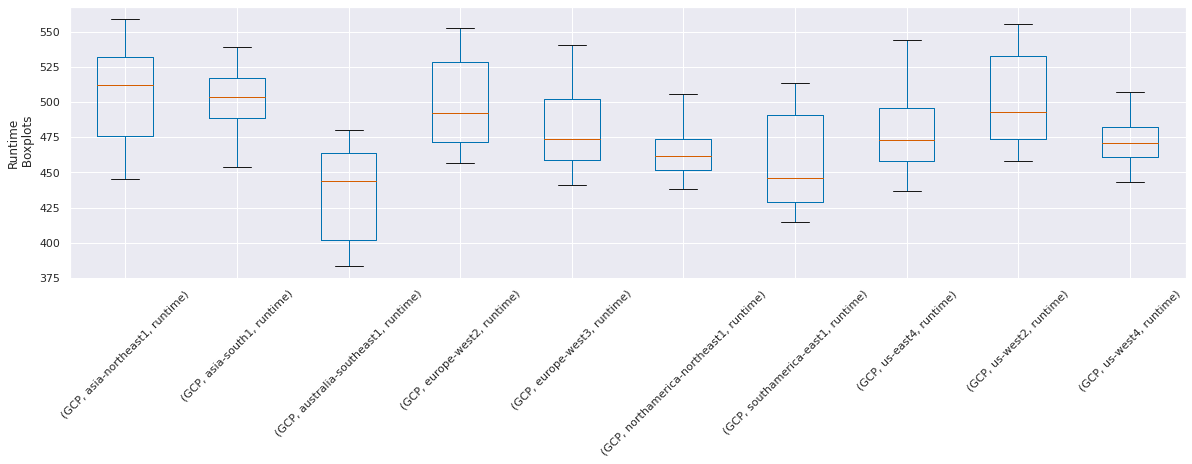

In [6]:
for provider in df['provider'].unique():
    SHAREX = True
    pdf = df[['provider', 'region', 'runtime']][df['provider'] == provider]
    regions = (pdf['region'].unique())
    no_regions = len(regions)
    fig, axes = plt.subplots(figsize=(20,5)) #, ncols=no_regions, frameon=False, sharex=SHAREX, sharey=True)
    index = 0
    pdf = utils.remove_outliers_group_quantiles(pdf, 'region', 'runtime')
    ax = violinplotutil.vioplot(pdf, axes, 'runtime')
    
    region_name_ax = ax
    labels = []
    for tick in region_name_ax.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
    region_name_ax.set_xticklabels(labels, rotation=45)
    region_name_ax.set_xlabel('')
    
    fig, axes = plt.subplots(figsize=(20,5)) #, ncols=no_regions, frameon=False, sharex=SHAREX, sharey=True)
    bxdf = pdf.groupby(['provider','region'], observed=True)
    utils.boxplot(axes, bxdf, "Runtime\n Boxplots", lambda x: x, rot=45, sharex=False)
    utils.plot( ['region_analysis', f'runtime_boxplot_all_provider'], bxdf=bxdf.describe())

In [7]:
cov_df

provider  region                 
AWS       ap-northeast-1             0.159860
          ap-south-1                 0.155950
          ap-southeast-2             0.149037
          ca-central-1               0.162341
          eu-central-1               0.142820
          eu-west-2                  0.149684
          sa-east-1                  0.142681
          us-east-1                  0.147155
          us-west-1                  0.162346
          us-west-2                  0.157484
AZURE     australiaeast              0.215222
          brazilsouth                0.285533
          centralindia               0.288335
          eastus                     0.277189
          germanywestcentral         0.359126
          japaneast                  0.265224
          uksouth                    0.300612
          westus                     0.369077
          westus2                    0.230395
GCP       asia-northeast1            0.269380
          asia-south1                0.154203


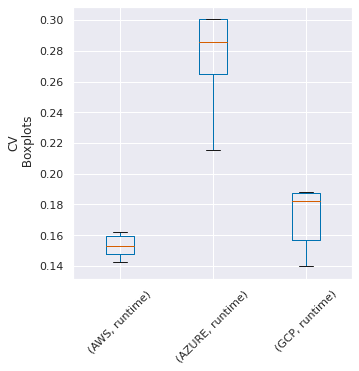

cvbx 
          runtime                                                              \
           count      mean       std       min       25%       50%       75%   
provider                                                                       
AWS         10.0  0.152936  0.007611  0.142681  0.147626  0.152817  0.159266   
AZURE        9.0  0.287857  0.051294  0.215222  0.265224  0.285533  0.300612   
GCP         10.0  0.179484  0.036893  0.139756  0.156874  0.182559  0.187235   

                    
               max  
provider            
AWS       0.162346  
AZURE     0.369077  
GCP       0.269380  


In [8]:
# CV Boxplots
cov_df.groupby('provider')
fig, axes = plt.subplots(figsize=(5,5))
    
bxdf = cov_df.reset_index().groupby(['provider'])
utils.boxplot(axes, bxdf, "CV\n Boxplots", lambda x: x, rot=45)
utils.plot( ['region_analysis', f'cv_boxplot'], cvbx=bxdf.describe())

In [9]:
mean_region_df = df[['provider', 'region', 'runtime']].groupby(['provider', 'region'], observed=True).mean()
mean_region_df

runtime
provider region                             
AWS      ap-northeast-1            69.427334
         ap-south-1                70.766613
         ap-southeast-2             71.11999
         ca-central-1              68.008027
         eu-central-1              68.283834
         eu-west-2                 67.111829
         sa-east-1                 65.861047
         us-east-1                 70.205833
         us-west-1                 69.545529
         us-west-2                 70.441714
AZURE    australiaeast             69.700843
         brazilsouth               57.343522
         centralindia              49.750074
         eastus                    73.360427
         germanywestcentral        51.235188
         japaneast                 61.805066
         uksouth                   57.530543
         westus                    72.688987
         westus2                   73.046884
GCP      asia-northeast1          513.364257
         asia-south1              503.950055
         australia-southeast1     435.261199
         europe-west2             499.227434
         europe-west3             485.096729
         northamerica-northeast1  465.929457
         southamerica-east1       455.811444
         us-east4                 485.707277
         us-west2                 499.789196
         us-west4                 472.343484

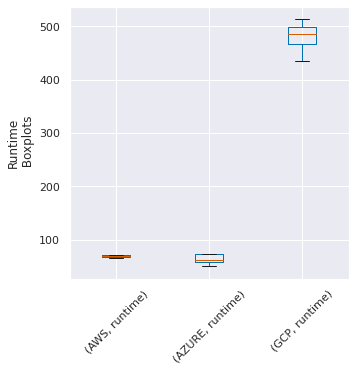

cvbx 
          runtime                                                             \
           count        mean        std         min         25%         50%   
provider                                                                      
AWS         10.0   69.077175   1.715408   65.861047   68.076979   69.486431   
AZURE        9.0   62.940171   9.515341   49.750074   57.343522   61.805066   
GCP         10.0  481.648053  24.318998  435.261199  467.532964  485.402003   

                                  
                 75%         max  
provider                          
AWS        70.382744   71.119990  
AZURE      72.688987   73.360427  
GCP       499.648755  513.364257  


In [10]:
# Runtime Boxplots
fig, axes = plt.subplots(figsize=(5,5))
    
bxdf = mean_region_df.groupby('provider')
utils.boxplot(axes, bxdf, "Runtime\n Boxplots", lambda x: x, rot=45)
utils.plot( ['region_analysis', f'runtime_boxplot'], cvbx=bxdf.describe())

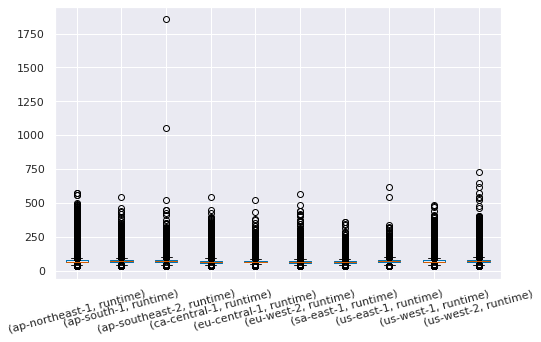

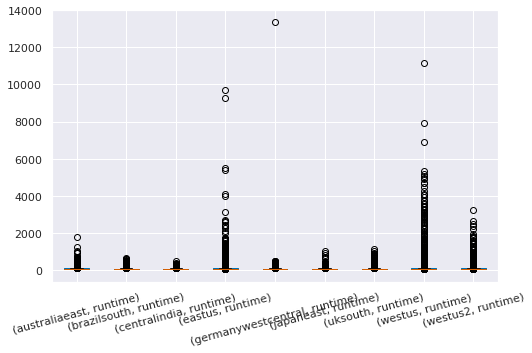

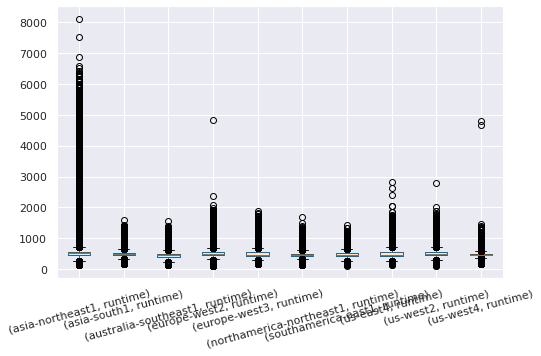

In [11]:
# Mean Runtime with Outliers
for provider in cov_df.index.get_level_values('provider').unique():
# Generate a control figure - because I cannot fore the matching
    fig, axes = plt.subplots(figsize=(8,5))
    df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
    for tick in axes.get_xticklabels():
        tick.set_rotation(15)
    plt.show()
    plt.close()

# CPU Types Analysis
Different Types of CPUs for the different regions.

In [12]:
unique_cpu_types_df = df.groupby(['provider', 'region', 'cpuType'], observed=True)['cpuType'].count() #.agg({'cpuType':'count'})
unique_cpu_types_df = pd.DataFrame(unique_cpu_types_df).groupby(['provider', 'region'], group_keys=False).apply(lambda df: (df['cpuType'] / df['cpuType'].sum()) * 100)
unique_cpu_types_percentage_df = pd.DataFrame(unique_cpu_types_df)
unique_cpu_types_percentage_df = unique_cpu_types_percentage_df.rename(columns={'cpuType': 'Percentage'})
unique_cpu_types_percentage_df = unique_cpu_types_percentage_df.reset_index('cpuType')
unique_cpu_types_pivoted_df = unique_cpu_types_percentage_df.pivot(columns=['cpuType'])

In [13]:
cpu_map = {
    "Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63": "Xeon @ 2.50GHz - Model 63",
    "Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz - Model 85": "Xeon Platinum 8171M CPU @ 2.60GHz - Model 85",
    "Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - Model 79": "Xeon CPU E5-2673 v4 @ 2.30GHz - Model 79",
    "Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz - Model 85": "Xeon Platinum 8272CL CPU @ 2.60GHz - Model 85",
    "Intel(R) Xeon(R) CPU E5-2673 v3 @ 2.40GHz - Model 63": "Xeon CPU E5-2673 v3 @ 2.40GHz - Model 63",
    "Intel(R) Xeon(R) Processor @ 3.00GHz - Model 63": "Xeon @ 3.00GHz - Model 63",
    "unknown - Model 85": "Model 85",
    "unknown - Model 79": "Model 79",
    "unknown - Model 63": "Model 63"
}

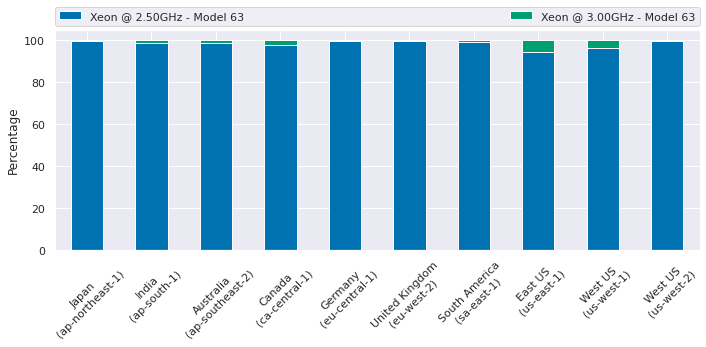

cpu_types_percentrage 
                 Xeon @ 2.50GHz - Model 63  Xeon @ 3.00GHz - Model 63
region                                                              
ap-northeast-1                  99.588313                   0.411687
ap-south-1                      98.645013                   1.354987
ap-southeast-2                  98.945640                   1.054360
ca-central-1                    97.880335                   2.119665
eu-central-1                    99.694243                   0.305757
eu-west-2                       99.931559                   0.068441
sa-east-1                       99.375028                   0.624972
us-east-1                       94.308619                   5.691381
us-west-1                       96.549660                   3.450340
us-west-2                       99.954666                   0.045334


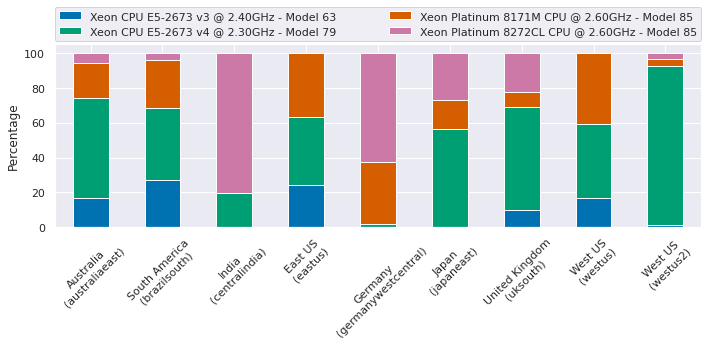

cpu_types_percentrage 
                     Xeon CPU E5-2673 v3 @ 2.40GHz - Model 63  \
region                                                         
australiaeast                                      16.797081   
brazilsouth                                        26.982614   
centralindia                                        0.309975   
eastus                                             24.544859   
germanywestcentral                                       NaN   
japaneast                                           0.076161   
uksouth                                            10.108581   
westus                                             16.786612   
westus2                                             1.140948   

                    Xeon CPU E5-2673 v4 @ 2.30GHz - Model 79  \
region                                                         
australiaeast                                      57.619793   
brazilsouth                                        41.387051   
centralindia   

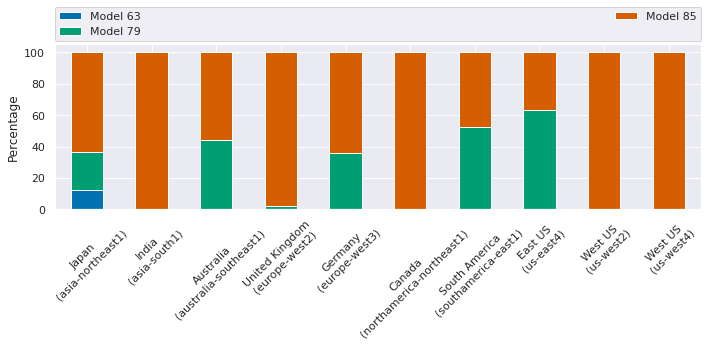

cpu_types_percentrage 
                          Model 63   Model 79    Model 85
region                                                  
asia-northeast1          12.31664  24.192825   63.490535
asia-south1                   NaN        NaN  100.000000
australia-southeast1          NaN  44.288705   55.711295
europe-west2                  NaN   2.091200   97.908800
europe-west3                  NaN  36.124145   63.875855
northamerica-northeast1       NaN        NaN  100.000000
southamerica-east1            NaN  52.392529   47.607471
us-east4                      NaN  63.604870   36.395130
us-west2                      NaN        NaN  100.000000
us-west4                      NaN        NaN  100.000000


In [14]:
for provider in df['provider'].unique():
    fig, axes = plt.subplots(figsize=(10,5))
    subdf = unique_cpu_types_pivoted_df

    providerdf = subdf.loc[provider]

    cols = providerdf.columns.droplevel(0)
    new_cols = [cpu_map[x] for x in cols]
    providerdf.columns = new_cols
    providerdf = providerdf.dropna(axis=1, how='all')
    
    providerdf.plot.bar(stacked=True, ax=axes, rot=45)

    axes.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
    axes.set_xlabel('')
    axes.set_ylabel('Percentage')
    
    # Set Region Names
    labels = []
    for tick in axes.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
    axes.set_xticklabels(labels)
    
    fig.tight_layout()
    utils.plot( ['region_analysis', f'cpu_types_{provider}'], cpu_types_percentrage=providerdf)

In [15]:
cputype_per_invocation_df = pd.DataFrame(df.groupby(['provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().rename('Count'))

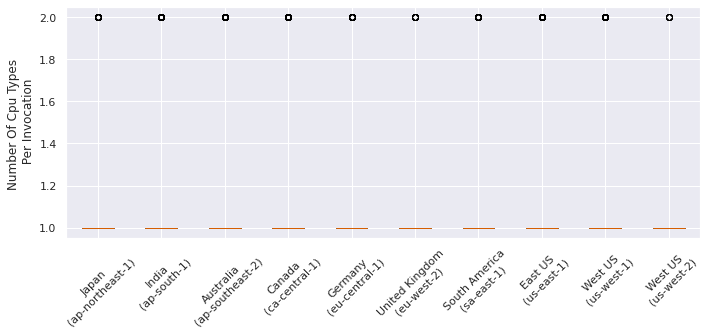

cputype_per_invocation_df 
                  Count                                             
                 count      mean       std  min  25%  50%  75%  max
region                                                             
ap-northeast-1  2895.0  1.014508  0.119592  1.0  1.0  1.0  1.0  2.0
ap-south-1      2894.0  1.045957  0.209428  1.0  1.0  1.0  1.0  2.0
ap-southeast-2  2896.0  1.034530  0.182619  1.0  1.0  1.0  1.0  2.0
ca-central-1    2897.0  1.072144  0.258770  1.0  1.0  1.0  1.0  2.0
eu-central-1    2895.0  1.011744  0.107752  1.0  1.0  1.0  1.0  2.0
eu-west-2       2893.0  1.002765  0.052522  1.0  1.0  1.0  1.0  2.0
sa-east-1       2893.0  1.019703  0.139001  1.0  1.0  1.0  1.0  2.0
us-east-1       2887.0  1.200208  0.400225  1.0  1.0  1.0  1.0  2.0
us-west-1       2893.0  1.092637  0.289974  1.0  1.0  1.0  1.0  2.0
us-west-2       2886.0  1.001733  0.041594  1.0  1.0  1.0  1.0  2.0


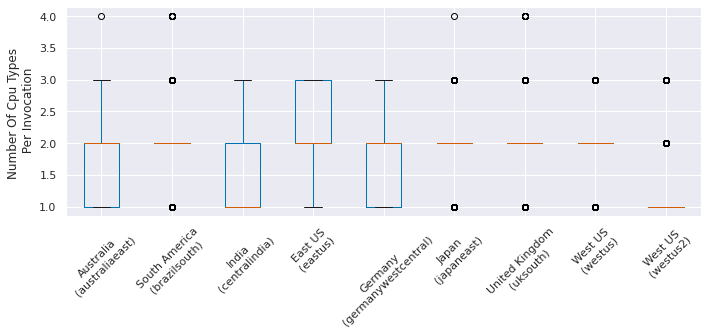

cputype_per_invocation_df 
                      Count                                             
                     count      mean       std  min  25%  50%  75%  max
region                                                                 
australiaeast       2884.0  1.901179  0.664974  1.0  1.0  2.0  2.0  4.0
brazilsouth         2880.0  2.062500  0.642576  1.0  2.0  2.0  2.0  4.0
centralindia        2895.0  1.450086  0.502426  1.0  1.0  1.0  2.0  3.0
eastus              2871.0  2.230930  0.584913  1.0  2.0  2.0  3.0  3.0
germanywestcentral  2897.0  1.651363  0.522252  1.0  1.0  2.0  2.0  3.0
japaneast           2894.0  1.991707  0.618809  1.0  2.0  2.0  2.0  4.0
uksouth             2893.0  2.031801  0.667118  1.0  2.0  2.0  2.0  4.0
westus              2843.0  2.074217  0.609374  1.0  2.0  2.0  2.0  3.0
westus2             2896.0  1.254144  0.497646  1.0  1.0  1.0  1.0  3.0


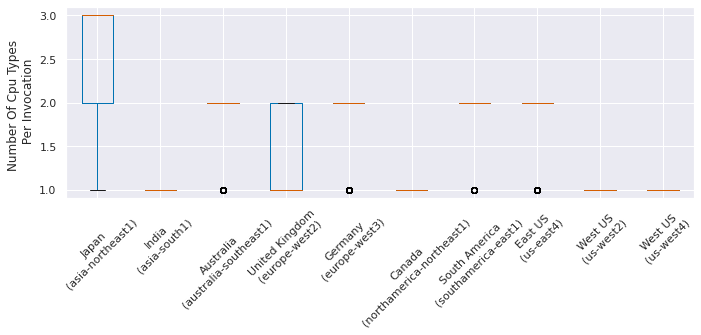

cputype_per_invocation_df 
                           Count                                             
                          count      mean       std  min  25%  50%  75%  max
region                                                                      
asia-northeast1          2900.0  2.682759  0.496326  1.0  2.0  3.0  3.0  3.0
asia-south1              2901.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
australia-southeast1     2901.0  1.971044  0.167710  1.0  2.0  2.0  2.0  2.0
europe-west2             2901.0  1.255084  0.435984  1.0  1.0  1.0  2.0  2.0
europe-west3             2901.0  1.925198  0.263117  1.0  2.0  2.0  2.0  2.0
northamerica-northeast1  2901.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
southamerica-east1       2900.0  1.986207  0.116651  1.0  2.0  2.0  2.0  2.0
us-east4                 2901.0  1.895898  0.305446  1.0  2.0  2.0  2.0  2.0
us-west2                 2900.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
us-west4                 2900.0  1.000000  0.000

In [16]:
for provider in df['provider'].unique():
    fig, axes = plt.subplots(figsize=(10,5))
    subdf = cputype_per_invocation_df
    provdf = subdf.loc[provider]
    provdf.boxplot(by='region', rot=45, ax=axes)
    
    # Set Region Names
    labels = []
    for tick in axes.get_xticklabels():
        region = tick.get_text()
        key = f"({provider}, {region})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")
    axes.set_xticklabels(labels)
    
    # Other Formatting
    axes.set_title('')
    fig.suptitle('')
    axes.set_xlabel('')
    axes.set_ylabel('Number Of Cpu Types \n Per Invocation')
    
    fig.tight_layout()
    utils.plot( ['region_analysis', f'invocation_cpu_types_{provider}'], cputype_per_invocation_df=provdf.groupby('region').describe())